# Kaggle Competition: Customer Churn Prediction 2020 (Post competition notebook)

## Machine learning supervised binary classification problem

### With a dataset containing information on customers of a telecommunications provider, the competition consists in predicting wether a customer will change telecommunications provider (will churn).

### For more information see: https://www.kaggle.com/competitions/customer-churn-prediction-2020/overview

#### Notebook author: Arnau Juanmarti
#### Last edited: March 20, 2023

## Table of Contents

* [0 SETTINGS](#0)
* [1 EXPLORATORY DATA ANALYSIS](#1)
	* [1.1 Distribution of target](#11)
	* [1.2 Distribution of numerical features and relationship with target](#12)
	* [1.3 Distribution of categorical features and relationship with target](#13)
* [2 PREPROCESSING](#2)
	* [2.1 Feature Engineering](#21)
		* [2.1.1 Consumption summaries](#211)
		* [2.1.2 Identifying individuals at risk](#212)
	* [2.2 Encoding](#22)
		* [2.2.1 Labeling](#221)
		* [2.2.2 One-Hot Encoding](#222)
	* [2.3 Scaling](#23)
* [3 MODELING](#3)
	* [3.1 Defining functions](#31)
	* [3.2 Base models](#32)
		* [3.2.1 Logistic Regression](#321)
			* [3.2.1.1 Training and predicting](#3211)
		* [3.2.2 LightGBM](#322)
			* [3.2.2.1 Training and predicting](#3221)
		* [3.2.3 Feature selection with Recursive Feature Elimination (RFECV)](#323)
			* [3.2.3.1 Logistic Regression](#3231)
			* [3.2.3.2 LightGBM](#3232)
	* [3.3 Final models](#33)
		* [3.3.1 Logistic Regression](#331)
			* [3.3.1.1 Hyperparameter optimization](#3311)
			* [3.3.1.2 Training and predicting](#3312)
		* [3.3.2 LightGBM](#332)
			* [3.3.2.1 Hyperparameter optimization](#3321)
			* [3.3.2.2 Training and predicting](#3322)
		* [3.3.3 XGBoost](#333)
			* [3.3.3.1 Hyperparameter optimization](#3331)
			* [3.3.3.2 Training and predicting](#3332)
		* [3.3.4 CatBoost](#334)
			* [3.3.4.1 Hyperparameter optimization](#3341)
			* [3.3.4.2 Training and predicting](#3342)
	* [3.4 Ensemble](#34)
		* [3.4.1 Unweighted mean and optimization of weights](#341)
		* [3.4.2 Stacking](#342)
* [4 SUBMISSION](#4)

# 0 SETTINGS <a class='anchor' id='0'></a>

#### 0.1 Specify notebook settings

In [1]:
## This is to make output cells scrollable horizontally when output does not fit the screen.
#from IPython.display import display, HTML
#display(HTML("<style>pre { white-space: pre !important; }</style>"))

## This is to ensure imported custom modules get loaded automatically when the module is edited.
%load_ext autoreload
%autoreload 2

#### 0.2 Specify project directory

In [2]:
import os
os.chdir('C:/Users/Arnau Juanmarti/machinelearning_projects/Kaggle Competitions/Predicting customer churn')

#### 0.3 Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import own_functions as own ## Module with own custom functions
from own_functions import df_summary

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.feature_selection import RFECV

import optuna

#### 0.4 Specify pandas display options

In [4]:
desired_width=320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns',50)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

#### 0.5 Import data

In [5]:
train = pd.read_csv('Original data/customer-churn-prediction-2020/train.csv')
test = pd.read_csv('Original data/customer-churn-prediction-2020/test.csv')
sampleSubmission = pd.read_csv('Original data/customer-churn-prediction-2020/sampleSubmission.csv')

#### 0.6 First inspection

In [6]:
df_summary(train)

Number of rows: 4250


,Type,N Unique Values,N Missings,% Missings,Values
state,object,51,0,0.0,"[OH, NJ, OH, OK, MA]"
account_length,int64,215,0,0.0,"[107, 137, 84, 75, 121]"
area_code,object,3,0,0.0,"[area_code_415, area_code_415, area_code_408, area_code_415, area_code_510]"
international_plan,object,2,0,0.0,"[no, no, yes, yes, no]"
voice_mail_plan,object,2,0,0.0,"[yes, no, no, no, yes]"
number_vmail_messages,int64,46,0,0.0,"[26, 0, 0, 0, 24]"
total_day_minutes,float64,1843,0,0.0,"[161.6, 243.4, 299.4, 166.7, 218.2]"
total_day_calls,int64,120,0,0.0,"[123, 114, 71, 113, 88]"
total_day_charge,float64,1843,0,0.0,"[27.47, 41.38, 50.9, 28.34, 37.09]"
total_eve_minutes,float64,1773,0,0.0,"[195.5, 121.2, 61.9, 148.3, 348.5]"


In [7]:
df_summary(test)

Number of rows: 750


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,750,0,0.0,"[1, 2, 3, 4, 5]"
state,object,51,0,0.0,"[KS, AL, IA, VT, NE]"
account_length,int64,175,0,0.0,"[128, 118, 62, 93, 174]"
area_code,object,3,0,0.0,"[area_code_415, area_code_510, area_code_415, area_code_510, area_code_415]"
international_plan,object,2,0,0.0,"[no, yes, no, no, no]"
voice_mail_plan,object,2,0,0.0,"[yes, no, no, no, no]"
number_vmail_messages,int64,39,0,0.0,"[25, 0, 0, 0, 0]"
total_day_minutes,float64,619,0,0.0,"[265.1, 223.4, 120.7, 190.7, 124.3]"
total_day_calls,int64,100,0,0.0,"[110, 98, 70, 114, 76]"
total_day_charge,float64,619,0,0.0,"[45.07, 37.98, 20.52, 32.42, 21.13]"


#### 0.7 Tagging variables

In [8]:
id = 'id'
target = 'churn'
features_original = [col for col in train.columns if col!='churn']

#### 0.8 Convert target to numeric

In [9]:
train[target] = train[target].replace({'no': 0, 'yes': 1})

# 1 EXPLORATORY DATA ANALYSIS <a class='anchor' id='1'></a>

## 1.1 Distribution of target <a class='anchor' id='11'></a>

Text(0.5, 0.98, 'Distribution of churn')

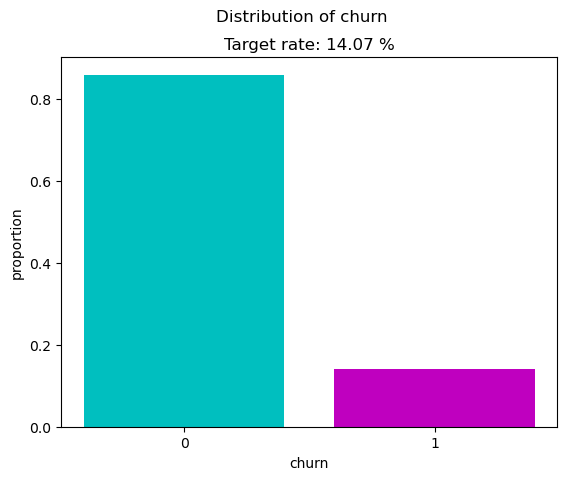

In [10]:
fig, ax = plt.subplots()
ax.bar(train[target].value_counts().index, train[target].value_counts().values/len(train), color=['c', 'm'])
ax.set_xticks(range(len(train[target].value_counts().index)), train[target].value_counts().index)
ax.set(xlabel=target, ylabel='proportion', title=f'Target rate: {round(np.mean(train[target])*100, 2)} %')
fig.suptitle(f'Distribution of {target}')

## 1.2 Distribution of numerical features and relationship with target <a class='anchor' id='12'></a>
The following figures shows a histogram of the numerical features for both train and test sets and a scatterplot of each features with the target rate.

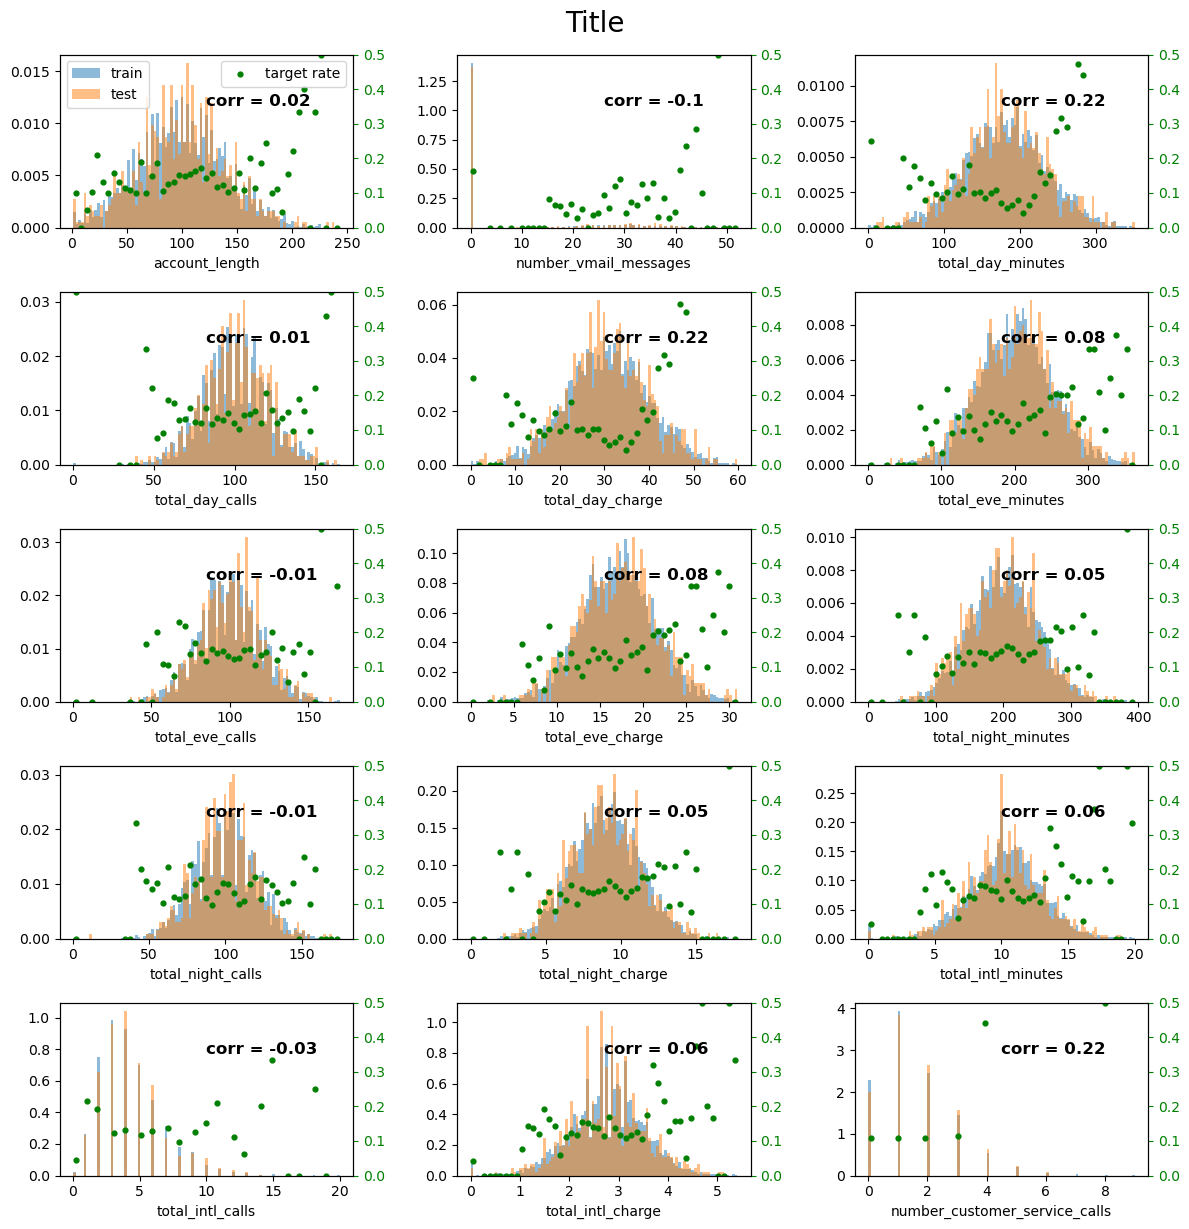

In [11]:
num_cols = [col for col in features_original if col not in ['state', 'area_code', 'international_plan', 'voice_mail_plan']]
own.plot_cont_target_all(train, test, num_cols, target, rows=5, cols=3, bins1=100, bins2=50, figsize=(12, 12))

## 1.3 Distribution of categorical features and relationship with target <a class='anchor' id='13'></a>
The following figure shows a histogram of each categorical feature for both train and test sets and the target rate by category for each feature.

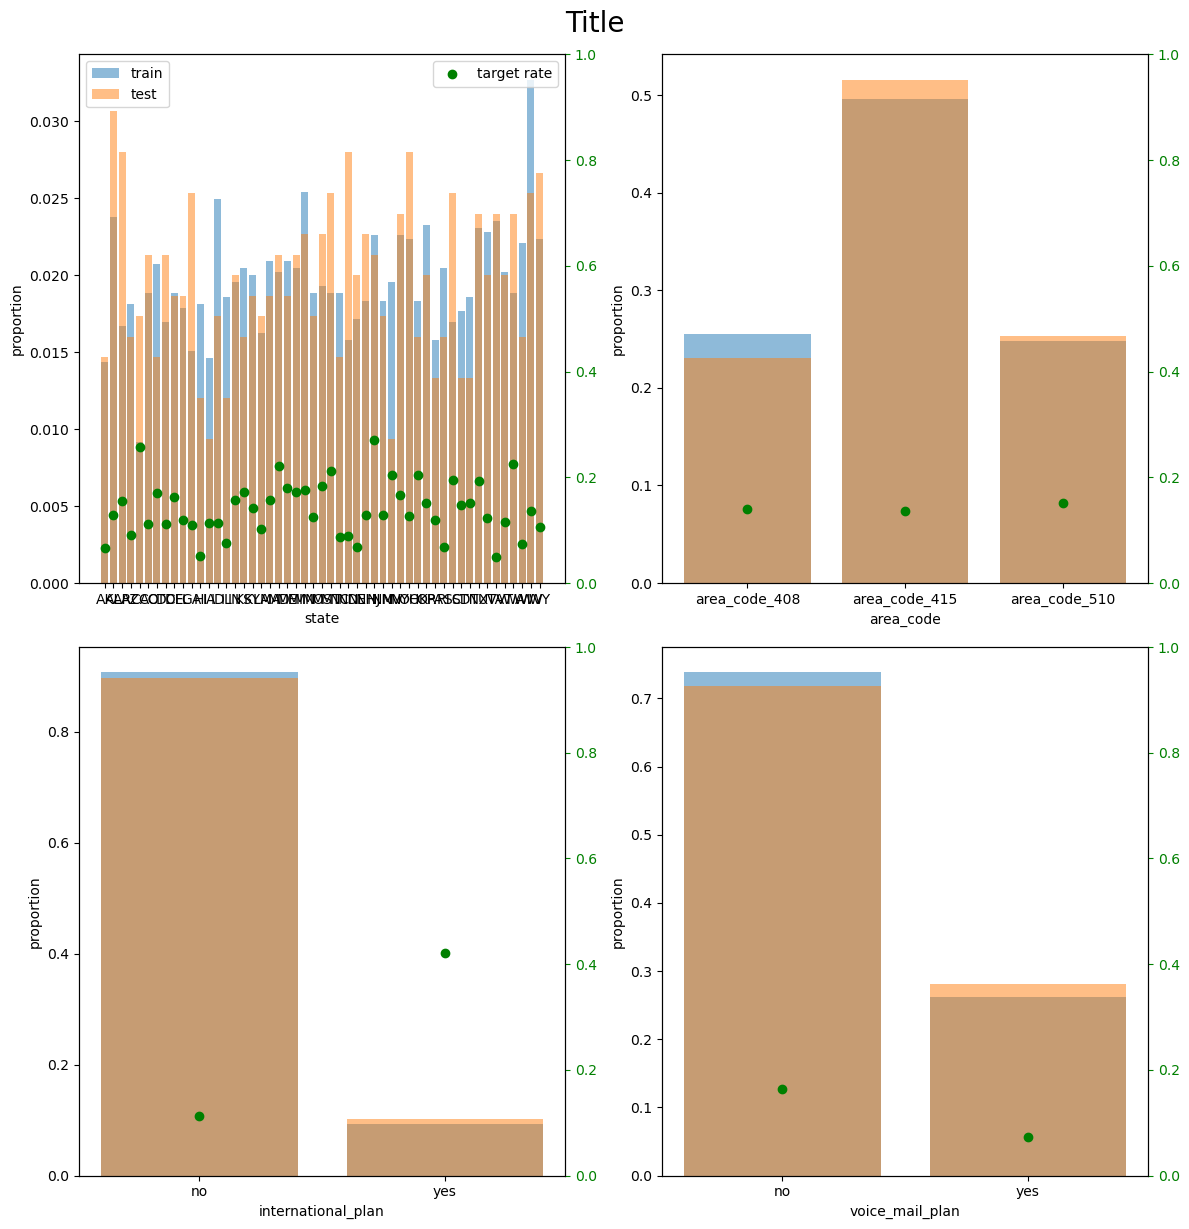

In [12]:
cat_cols = [col for col in features_original if col not in num_cols]
own.plot_cat_target_all(train, test, cat_cols, target, rows=2, cols=2, figsize=(12, 12))

# 2 PREPROCESSING <a class='anchor' id='2'></a>

## 2.1 Feature Engineering <a class='anchor' id='21'></a>

### 2.1.1 Consumption summaries <a class='anchor' id='211'></a>
We generate new features using the original features relating to consumption (usage and charges). The new features may provide useful imformation for predicting churn.

In [13]:
## Generate totals for usage and charges
for df in [train, test]:
    df['total_minutes'] = df[['total_day_minutes', 'total_eve_minutes', 'total_night_minutes']].sum(axis=1)
    df['total_calls'] = df[['total_day_calls', 'total_eve_calls', 'total_night_calls']].sum(axis=1)
    df['total_charge'] = df[['total_day_charge', 'total_eve_charge', 'total_night_charge']].sum(axis=1)
    
## Generate average consumption and average charges
for df in [train, test]:
    df['avg_day_call_minutes'] = df['total_day_minutes'] / df['total_day_calls']
    df['avg_day_call_charge'] = df['total_day_charge'] / df['total_day_calls']
    df['avg_day_minute_charge'] = df['total_day_charge'] / df['total_day_minutes']
    
    df['avg_eve_call_minutes'] = df['total_eve_minutes'] / df['total_eve_calls']
    df['avg_eve_call_charge'] = df['total_eve_charge'] / df['total_eve_calls']
    df['avg_eve_minute_charge'] = df['total_eve_charge'] / df['total_eve_minutes']
    
    df['avg_night_call_minutes'] = df['total_night_minutes'] / df['total_night_calls']
    df['avg_night_call_charge'] = df['total_night_charge'] / df['total_night_calls']
    df['avg_night_minute_charge'] = df['total_night_charge'] / df['total_night_minutes']
    
    df['avg_intl_call_minutes'] = df['total_intl_minutes'] / df['total_intl_calls']
    df['avg_intl_call_charge'] = df['total_intl_charge'] / df['total_intl_calls']
    df['avg_intl_minute_charge'] = df['total_intl_charge'] / df['total_intl_minutes']
    
    df['avg_total_call_minutes'] = df['total_minutes'] / df['total_calls']
    df['avg_total_call_charge'] = df['total_charge'] / df['total_calls']
    df['avg_total_minute_charge'] = df['total_charge'] / df['total_minutes']

## For individuals with no consumption, fill averages with 0
for df in [train, test]:
    df.fillna(0, inplace=True)

## Identify individuals with no consumption
for df in [train, test]:
    df['no_consumption'] = np.where(df['total_calls'] == 0, 1, 0)

## List with new features
features_consumption_summaries = ['total_minutes', 'total_calls', 'total_charge', 'avg_day_call_minutes',
                                  'avg_day_call_charge', 'avg_day_minute_charge', 'avg_eve_call_minutes',
                                 'avg_eve_call_charge', 'avg_eve_minute_charge', 'avg_night_call_minutes',
                                 'avg_night_call_charge', 'avg_night_minute_charge', 'avg_intl_call_minutes',
                                 'avg_intl_call_charge', 'avg_intl_minute_charge', 'avg_total_call_minutes',
                                 'avg_total_call_charge', 'avg_total_minute_charge', 'no_consumption']

### 2.1.2 Identifying individuals at risk <a class='anchor' id='212'></a>
We generate indicators capturing individuals that may have a greater tendency to churn based on potential "risk factors"

In [14]:
## Individuals that consume and pay a lot
for df in [train, test]:
    df['heavy_user_high_charge_day'] = np.where(
        (df['total_day_minutes'] > train['total_day_minutes'].quantile(q=0.75)) &
        (df['total_day_charge'] > train['total_day_charge'].quantile(q=0.75)), 1, 0)

    df['heavy_user_high_charge_eve'] = np.where(
        (df['total_eve_minutes'] > train['total_eve_minutes'].quantile(q=0.75)) &
        (df['total_eve_charge'] > train['total_eve_charge'].quantile(q=0.75)), 1, 0)

    df['heavy_user_high_charge_night'] = np.where(
        (df['total_night_minutes'] > train['total_night_minutes'].quantile(q=0.75)) &
        (df['total_night_charge'] > train['total_night_charge'].quantile(q=0.75)), 1, 0)
    
    df['heavy_user_high_charge_intl'] = np.where(
        (df['total_intl_minutes'] > train['total_intl_minutes'].quantile(q=0.75)) &
        (df['total_intl_charge'] > train['total_intl_charge'].quantile(q=0.75)), 1, 0)

    df['heavy_user_high_charge_total'] = np.where(
        (df['total_minutes'] > train['total_minutes'].quantile(q=0.75)) &
        (df['total_charge'] > train['total_charge'].quantile(q=0.75)), 1, 0)

## Individuals with at least 1 customer service call
for df in [train, test]:
    df['customer_service_call'] = np.where(df['number_customer_service_calls'] >= 1, 1, 0)

## List of new features
features_risk = ['heavy_user_high_charge_day', 'heavy_user_high_charge_eve', 'heavy_user_high_charge_night',
                 'heavy_user_high_charge_intl', 'heavy_user_high_charge_total', 'customer_service_call']

## 2.2 Encoding <a class='anchor' id='22'></a>

### 2.2.1 Labeling <a class='anchor' id='221'></a>

In [15]:
## Labeling dummy features
train['international_plan'] = train['international_plan'].replace({'no': 0, 'yes': 1})
test['international_plan'] = test['international_plan'].replace({'no': 0, 'yes': 1})

train['voice_mail_plan'] = train['voice_mail_plan'].replace({'no': 0, 'yes': 1})
test['voice_mail_plan'] = test['voice_mail_plan'].replace({'no': 0, 'yes': 1})

'''
## Labeling other features (not used because we use one-hot-encoding below)
label_cols = ['state', 'area_code']

le = LabelEncoder()
for col in label_cols:
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
'''

"\n## Labeling other features (not used because we use one-hot-encoding below)\nlabel_cols = ['state', 'area_code']\n\nle = LabelEncoder()\nfor col in label_cols:\n    le.fit(train[col])\n    train[col] = le.transform(train[col])\n    test[col] = le.transform(test[col])\n"

### 2.2.2 One-Hot Encoding <a class='anchor' id='222'></a>

In [16]:
## One-Hot Encoding the categorical features
ohe_cols = ['state', 'area_code']

train, test = own.onehotencode(train, test, ohe_cols)

## 2.3 Scaling <a class='anchor' id='23'></a>

In [17]:
## Scaling the numerical features
scale_cols = [col for col in features_original if col not in ['state', 'area_code']] + features_consumption_summaries

sc = StandardScaler()

train[scale_cols] = sc.fit_transform(train[scale_cols])
test[scale_cols] = sc.transform(test[scale_cols])

# 3 MODELING <a class='anchor' id='3'></a>

## 3.1 Defining functions <a class='anchor' id='31'></a>

##### Function to train model and generate out-of-fold and test predictions from cross-validation
This function is used to train the models that will be used and to generate oof and test predictions from cross-validation. Because the target is imbalanced, we use stratified cross-validation (with 10 folds and random shuffle). The function returns arrays of oof and test predictions (both for binary outcome and for probabilities) and a list of feature importances.

In [18]:
def train_and_predict(model, train, test, features, target, n_splits, fit_params={}, importances=False, evaluation=True):

    preds_oof_bin = np.zeros(train.shape[0])
    preds_oof_proba = np.zeros(train.shape[0])
    preds_test_bin = []
    preds_test_proba = np.zeros(test.shape[0])
    folds_score = []
    importances_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = model
        if evaluation==True:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **fit_params)
        else:
            model.fit(X_train, y_train, **fit_params)

        pred_val = model.predict(X_val)
        preds_oof_bin[val_idx] = pred_val
        pred_val_proba = model.predict_proba(X_val)[:,1]
        preds_oof_proba[val_idx] = pred_val_proba

        pred_test = model.predict(test[features])
        pred_test_proba = model.predict_proba(test[features])[:,1]
        preds_test_bin.append(pred_test)
        preds_test_proba += pred_test_proba / n_splits

        fold_score = accuracy_score(y_val, np.where(pred_val_proba >= 0.5, 1, 0))
        folds_score.append(fold_score)
        
        if importances==True:
            importances_list.append(model.coef_.ravel())

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    print(f'OOF SCORE: {accuracy_score(train[target], np.where(preds_oof_proba >= 0.5, 1, 0))}')

    preds_test_bin = np.where(np.sum(np.array(preds_test_bin).T, axis=1) >= 5, 1, 0)
    
    if importances==True:
        return preds_oof_bin, preds_oof_proba, preds_test_bin, preds_test_proba, importances_list
    else:
        return preds_oof_bin, preds_oof_proba, preds_test_bin, preds_test_proba

##### Function to perform Recursive Feature Elimination (RFECV)
This function performs recursive feature elimination and returns a dataframe with the features ranked, a list of the selected features, a list of the not selected features and the best CV score. It also shows a figure with the CV results.

In [19]:
def rfecv_custom(estimator, cv, scoring, X, y, name):
    rfecv = RFECV(estimator=estimator, cv=cv, scoring=scoring, verbose=100)
    rfecv.fit(X, y)

    cv_results_df = pd.DataFrame(rfecv.cv_results_)
    n_features_selected = rfecv.n_features_
    features_selected_bool = rfecv.support_.tolist()
    features_selected_ranking = rfecv.ranking_.tolist()
    best_cv_score = cv_results_df['mean_test_score'].sort_values(ascending=False).reset_index(drop=True)[0]

    rfe_df = pd.DataFrame(columns=['Feature', 'Selected', 'Ranking'])
    rfe_df['Feature'] = X.columns
    rfe_df['Selected'] = features_selected_bool
    rfe_df['Ranking'] = features_selected_ranking
    selected_features = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()
    notselected_features = rfe_df[rfe_df['Selected'] == False]['Feature'].tolist()
    rfe_df.sort_values(by='Ranking', ascending=True, inplace=True)
    rfe_df.reset_index(drop=True, inplace=True)

    print(rfe_df)
    print(' ')
    print('Optimal number of features: ' + str(n_features_selected) + ' (from ' + str(X.shape[1]) + ')')
    print(' ')
    print('CV Score: ' + str(best_cv_score))
    print(' ')
    print('Features selected: ')
    print(selected_features)
    print(' ')
    print('Features not selected: ')
    print(notselected_features)

    plt.figure(figsize=(10, 6))
    plt.suptitle('Cross-validation mean score for RFE', fontsize=18)
    plt.title(
        'Best CV score: ' + str(round(best_cv_score, 4)) + '\n' + 'N features selected: ' + str(n_features_selected),
        fontsize=10)
    plt.xlabel('Number of features selected')
    plt.ylabel('CV Score')
    plt.plot(range(1, cv_results_df.shape[0] + 1), cv_results_df['mean_test_score'])
    plt.xticks(ticks=range(1, cv_results_df.shape[0] + 1), labels=range(1, cv_results_df.shape[0] + 1))
    plt.axvline(x=n_features_selected, linestyle='dashed', color='k')
    #plt.show()
    plt.savefig('Figures/rfecv_' + name + '.pdf')

    return rfe_df, selected_features, notselected_features, best_cv_score

## 3.2 Base models <a class='anchor' id='32'></a>
We start with two base models: Logistic Regression and LightGBM. These models have been used to evaluate the improvement in performance of the preprocessing steps above.

### 3.2.1 Logistic Regression <a class='anchor' id='321'></a>

#### 3.2.1.1 Training and predicting <a class='anchor' id='3211'></a>

In [20]:
model = LogisticRegression(random_state=100)
features = [col for col in train.columns if col!='churn']
preds_oof_bin_lr, preds_oof_proba_lr, preds_test_bin_lr, preds_test_proba_lr, importances_list_lr = train_and_predict(model, train, test, features, target, 10, fit_params={}, importances=True, evaluation=False)

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

FOLD 0 SCORE: 0.8988235294117647
FOLD 1 SCORE: 0.8541176470588235
FOLD 2 SCORE: 0.8611764705882353


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

FOLD 3 SCORE: 0.8894117647058823
FOLD 4 SCORE: 0.9035294117647059
FOLD 5 SCORE: 0.8823529411764706
FOLD 6 SCORE: 0.8729411764705882
FOLD 7 SCORE: 0.8776470588235294


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

FOLD 8 SCORE: 0.8588235294117647
FOLD 9 SCORE: 0.8870588235294118
MEAN CV SCORE: 0.8785882352941176
OOF SCORE: 0.8785882352941177


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Feature importances

Text(0, 0.5, 'Feature')

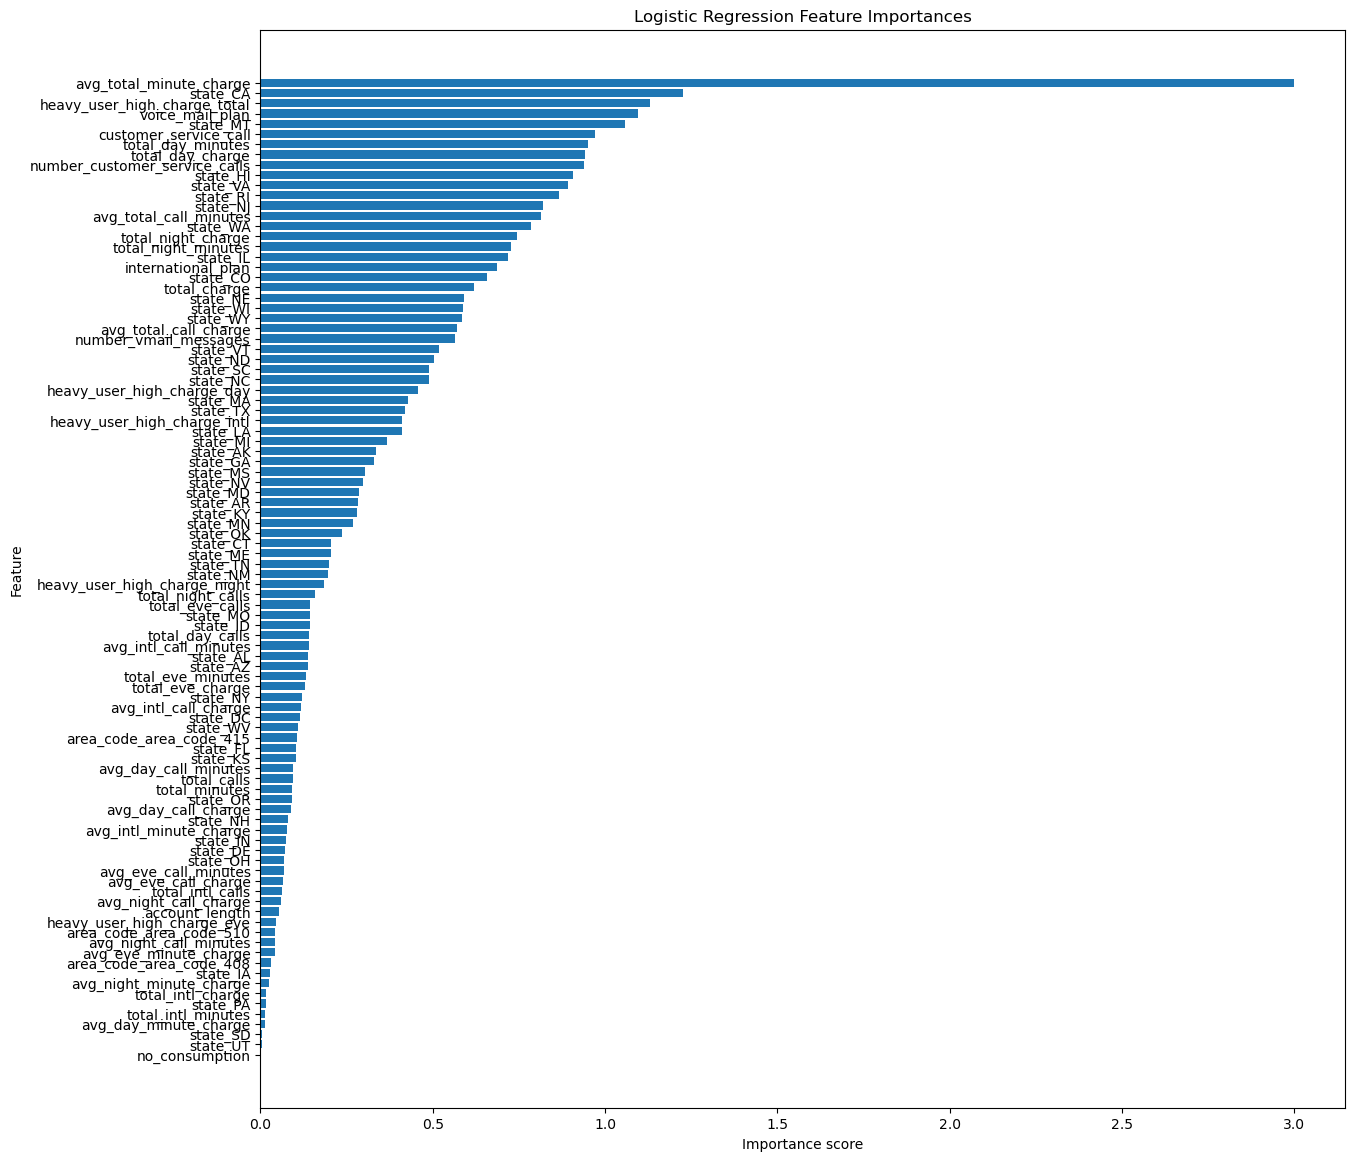

In [21]:
importance_mean = np.absolute(np.mean(np.array(importances_list_lr), axis=0))
importances_df = pd.DataFrame({'feature': features, 'importance': importance_mean}).sort_values('importance', ascending=False)
plt.figure(figsize=(14, 14))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.gca().invert_yaxis()
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Importance score')
plt.ylabel('Feature')

### 3.2.2 LightGBM <a class='anchor' id='322'></a>

#### 3.2.2.1 Training and predicting <a class='anchor' id='3221'></a>

In [22]:
model = LGBMClassifier(random_state=100, objective='binary')
features = [col for col in train.columns if col!='churn']
preds_oof_bin_lgbm, preds_oof_proba_lgbm, preds_test_bin_lgbm, preds_test_proba_lgbm = train_and_predict(model, train, test, features, target, 10, fit_params={}, importances=False, evaluation=True)

[1]	valid_0's binary_logloss: 0.332558
[2]	valid_0's binary_logloss: 0.292169
[3]	valid_0's binary_logloss: 0.263457
[4]	valid_0's binary_logloss: 0.242179
[5]	valid_0's binary_logloss: 0.224799
[6]	valid_0's binary_logloss: 0.209551
[7]	valid_0's binary_logloss: 0.198547
[8]	valid_0's binary_logloss: 0.188497
[9]	valid_0's binary_logloss: 0.179075
[10]	valid_0's binary_logloss: 0.17221
[11]	valid_0's binary_logloss: 0.166212
[12]	valid_0's binary_logloss: 0.160271
[13]	valid_0's binary_logloss: 0.154611
[14]	valid_0's binary_logloss: 0.150044
[15]	valid_0's binary_logloss: 0.146194
[16]	valid_0's binary_logloss: 0.143393
[17]	valid_0's binary_logloss: 0.14074
[18]	valid_0's binary_logloss: 0.138617
[19]	valid_0's binary_logloss: 0.136774
[20]	valid_0's binary_logloss: 0.134362
[21]	valid_0's binary_logloss: 0.133676
[22]	valid_0's binary_logloss: 0.132128
[23]	valid_0's binary_logloss: 0.132147
[24]	valid_0's binary_logloss: 0.131316
[25]	valid_0's binary_logloss: 0.129306
[26]	valid_

[48]	valid_0's binary_logloss: 0.151844
[49]	valid_0's binary_logloss: 0.153012
[50]	valid_0's binary_logloss: 0.153576
[51]	valid_0's binary_logloss: 0.154471
[52]	valid_0's binary_logloss: 0.155127
[53]	valid_0's binary_logloss: 0.154969
[54]	valid_0's binary_logloss: 0.155382
[55]	valid_0's binary_logloss: 0.15493
[56]	valid_0's binary_logloss: 0.155049
[57]	valid_0's binary_logloss: 0.154954
[58]	valid_0's binary_logloss: 0.156185
[59]	valid_0's binary_logloss: 0.157157
[60]	valid_0's binary_logloss: 0.157711
[61]	valid_0's binary_logloss: 0.159019
[62]	valid_0's binary_logloss: 0.159368
[63]	valid_0's binary_logloss: 0.160954
[64]	valid_0's binary_logloss: 0.160708
[65]	valid_0's binary_logloss: 0.16205
[66]	valid_0's binary_logloss: 0.163129
[67]	valid_0's binary_logloss: 0.163516
[68]	valid_0's binary_logloss: 0.163708
[69]	valid_0's binary_logloss: 0.163175
[70]	valid_0's binary_logloss: 0.163254
[71]	valid_0's binary_logloss: 0.164147
[72]	valid_0's binary_logloss: 0.164048
[7

[97]	valid_0's binary_logloss: 0.0723086
[98]	valid_0's binary_logloss: 0.0725014
[99]	valid_0's binary_logloss: 0.0727255
[100]	valid_0's binary_logloss: 0.0722618
FOLD 4 SCORE: 0.9835294117647059
[1]	valid_0's binary_logloss: 0.336848
[2]	valid_0's binary_logloss: 0.296784
[3]	valid_0's binary_logloss: 0.268896
[4]	valid_0's binary_logloss: 0.247193
[5]	valid_0's binary_logloss: 0.230018
[6]	valid_0's binary_logloss: 0.215705
[7]	valid_0's binary_logloss: 0.203862
[8]	valid_0's binary_logloss: 0.193572
[9]	valid_0's binary_logloss: 0.185168
[10]	valid_0's binary_logloss: 0.178183
[11]	valid_0's binary_logloss: 0.172077
[12]	valid_0's binary_logloss: 0.166869
[13]	valid_0's binary_logloss: 0.162082
[14]	valid_0's binary_logloss: 0.157753
[15]	valid_0's binary_logloss: 0.154602
[16]	valid_0's binary_logloss: 0.152351
[17]	valid_0's binary_logloss: 0.149995
[18]	valid_0's binary_logloss: 0.147428
[19]	valid_0's binary_logloss: 0.145323
[20]	valid_0's binary_logloss: 0.143709
[21]	valid_

[11]	valid_0's binary_logloss: 0.163023
[12]	valid_0's binary_logloss: 0.157517
[13]	valid_0's binary_logloss: 0.15207
[14]	valid_0's binary_logloss: 0.147081
[15]	valid_0's binary_logloss: 0.142641
[16]	valid_0's binary_logloss: 0.139105
[17]	valid_0's binary_logloss: 0.135845
[18]	valid_0's binary_logloss: 0.133124
[19]	valid_0's binary_logloss: 0.130697
[20]	valid_0's binary_logloss: 0.128738
[21]	valid_0's binary_logloss: 0.126956
[22]	valid_0's binary_logloss: 0.125835
[23]	valid_0's binary_logloss: 0.125298
[24]	valid_0's binary_logloss: 0.124409
[25]	valid_0's binary_logloss: 0.123476
[26]	valid_0's binary_logloss: 0.122708
[27]	valid_0's binary_logloss: 0.121502
[28]	valid_0's binary_logloss: 0.120872
[29]	valid_0's binary_logloss: 0.12083
[30]	valid_0's binary_logloss: 0.120632
[31]	valid_0's binary_logloss: 0.120281
[32]	valid_0's binary_logloss: 0.120787
[33]	valid_0's binary_logloss: 0.121129
[34]	valid_0's binary_logloss: 0.120935
[35]	valid_0's binary_logloss: 0.120914
[3

[65]	valid_0's binary_logloss: 0.110937
[66]	valid_0's binary_logloss: 0.1117
[67]	valid_0's binary_logloss: 0.113024
[68]	valid_0's binary_logloss: 0.113034
[69]	valid_0's binary_logloss: 0.113966
[70]	valid_0's binary_logloss: 0.114381
[71]	valid_0's binary_logloss: 0.114523
[72]	valid_0's binary_logloss: 0.114613
[73]	valid_0's binary_logloss: 0.115401
[74]	valid_0's binary_logloss: 0.115335
[75]	valid_0's binary_logloss: 0.115072
[76]	valid_0's binary_logloss: 0.115637
[77]	valid_0's binary_logloss: 0.115751
[78]	valid_0's binary_logloss: 0.116205
[79]	valid_0's binary_logloss: 0.117134
[80]	valid_0's binary_logloss: 0.117666
[81]	valid_0's binary_logloss: 0.117914
[82]	valid_0's binary_logloss: 0.118634
[83]	valid_0's binary_logloss: 0.119367
[84]	valid_0's binary_logloss: 0.120219
[85]	valid_0's binary_logloss: 0.120603
[86]	valid_0's binary_logloss: 0.120561
[87]	valid_0's binary_logloss: 0.121
[88]	valid_0's binary_logloss: 0.121427
[89]	valid_0's binary_logloss: 0.122042
[90]	

##### Feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

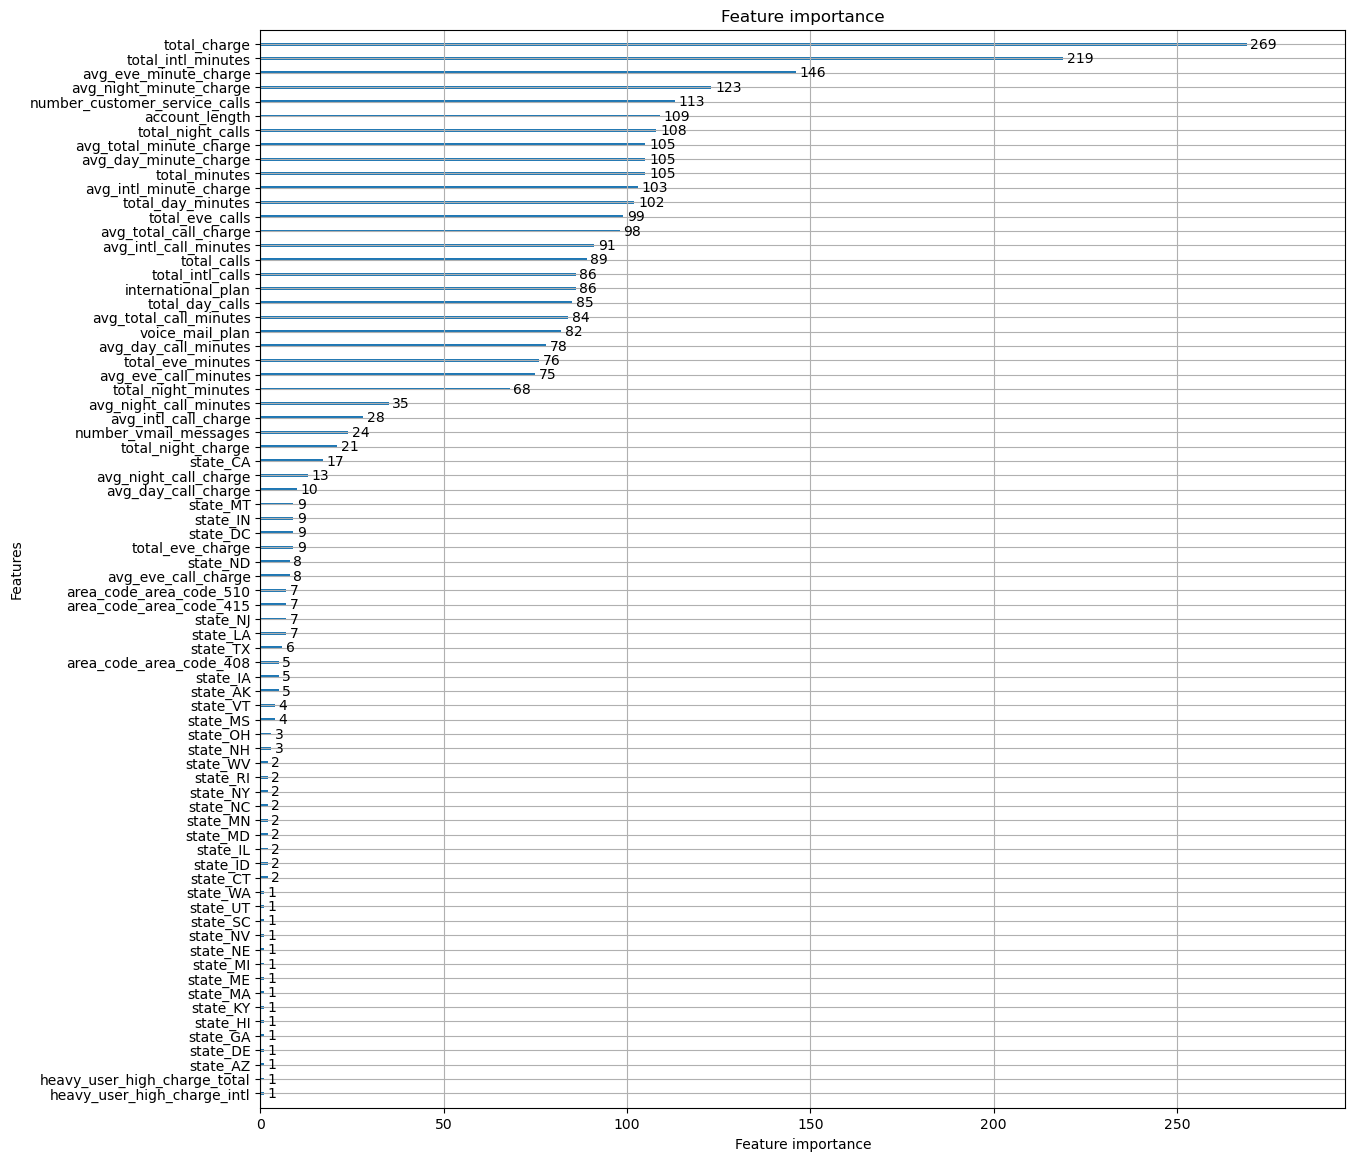

In [23]:
model = LGBMClassifier(random_state=100, objective='binary')
features = [col for col in train.columns if col!='churn']
model.fit(train[features], train[target])
lightgbm.plot_importance(model, figsize=(14, 14))

### 3.2.3 Feature selection with Recursive Feature Elimination (RFECV) <a class='anchor' id='323'></a>
Let's see if we can increase performance by performing automatic feature selection. We perform RFECV separately for Logistic Regression and for LightGBM.

#### 3.2.3.1 Logistic Regression <a class='anchor' id='3231'></a>

Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 87 features.
Fitting estimator with 86 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.


C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Arnau Juanmarti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

                          Feature  Selected  Ranking
0                        state_CO      True        1
1                        state_KS      True        1
2                        state_IL      True        1
3                        state_SC      True        1
4                        state_HI      True        1
5                        state_GA      True        1
6                        state_CT      True        1
7                        state_KY      True        1
8         area_code_area_code_415      True        1
9                        state_AR      True        1
10                       state_AL      True        1
11                       state_AK      True        1
12          customer_service_call      True        1
13    heavy_user_high_charge_intl      True        1
14   heavy_user_high_charge_night      True        1
15                       state_CA      True        1
16                       state_TN      True        1
17                       state_LA      True   

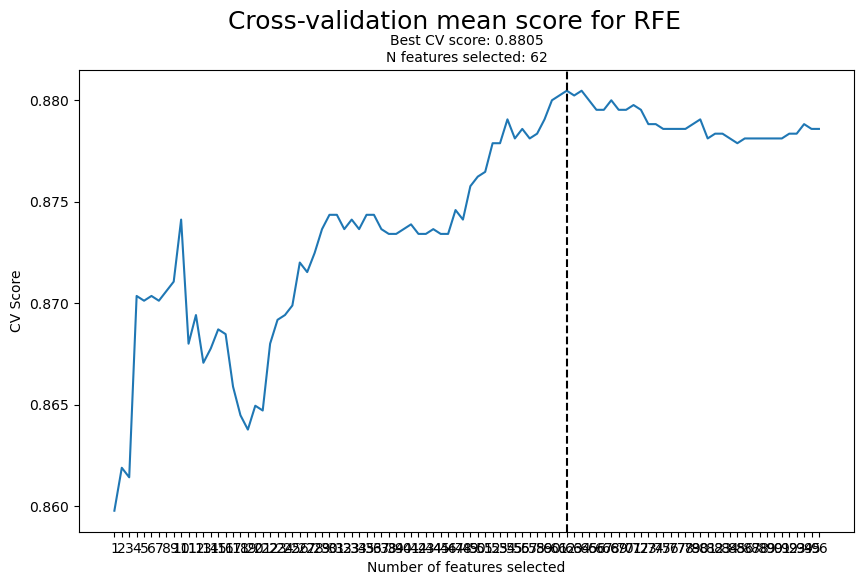

In [24]:
model = LogisticRegression(random_state=100)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
rfe_df, selected_features_lr, notselected_features, best_cv_score = rfecv_custom(model, skf, 'accuracy', train[features], train[target], 'lr')

with open('Tables/selected_features_lr.pickle', 'wb') as handle:
    pickle.dump(selected_features_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('Tables/selected_features_lr.pickle', 'rb') as handle:
    selected_features_lr = pickle.load(handle)

##### Takwaways:
1. The algorithm selects 62 out of the 96 features and there is a small increase in performance. We keep the selected features to include in the final Logistic Regression model below.

#### 3.2.3.2 LightGBM <a class='anchor' id='3232'></a>

In [25]:
model = LGBMClassifier(random_state=100, objective='binary')
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
rfe_df, selected_features_lgbm, notselected_features, best_cv_score = rfecv_custom(model, skf, 'accuracy', train[features], train[target], 'lgbm')

with open('Tables/selected_features_lgbm.pickle', 'wb') as handle:
    pickle.dump(selected_features_lgbm, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('Tables/selected_features_lgbm.pickle', 'rb') as handle:
    selected_features_lgbm = pickle.load(handle)

Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 fe

KeyboardInterrupt: 

##### Takwaways:
1. The algorithm selects 24 out of the 96 features and there is a small increase in performance. We keep the selected features to include in the final tree-based models below.

## 3.3 Final models <a class='anchor' id='33'></a>

##### Dataframes to save oof and test predictions

In [ ]:
preds_oof_bin_df = pd.DataFrame()
preds_test_bin_df = pd.DataFrame()

preds_oof_proba_df = pd.DataFrame()
preds_test_proba_df = pd.DataFrame()

### 3.3.1 Logistic Regression <a class='anchor' id='331'></a>

#### 3.3.1.1 Hyperparameter optimization <a class='anchor' id='3311'></a>
I've performed hyperparameter optimization but there is no improvement from the default hyperparameters. Possibly narrowing down the hyperparameter search space obtains better results.
(PENDING: Maybe define a reusable function to perform the optuna optimization for the individual models)

In [ ]:
'''
def objective(trial):
    
    params = {
        "random_state": trial.suggest_categorical("random_state", [100]),
        "C": trial.suggest_float("C", 0.001, 1000),
        "penalty": trial.suggest_categorical("penalty", ["l1"]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        "solver": trial.suggest_categorical("solver", ["liblinear"]),
        "max_iter": trial.suggest_int("max_iter", 100, 1000)
    }
    
    features = selected_features_lr

    preds_oof_lr = np.zeros(train.shape[0])
    folds_score = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        #, penalty='l1', C=0.01, solver='liblinear'
        model = LogisticRegression(random_state=100)
        model.fit(X_train, y_train)

        pred_val = model.predict(X_val)
        preds_oof_lr[val_idx] = pred_val

        fold_score = accuracy_score(y_val, pred_val)
        folds_score.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    
    return np.mean(folds_score)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

lr_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/lr_optuna_best.pickle', 'wb') as handle:
    pickle.dump(lr_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

with open('Tables/lr_optuna_best.pickle', 'rb') as handle:
    lr_optuna_best = pickle.load(handle)

#### 3.3.1.2 Training and predicting <a class='anchor' id='3312'></a>
Train, predict and save the predictions.

In [ ]:
model = LogisticRegression(random_state=100)
features = selected_features_lr
preds_oof_bin_df['lr'], preds_oof_proba_df['lr'], preds_test_bin_df['lr'], preds_test_proba_df['lr'] = train_and_predict(model, train, test, features, target, 10, evaluation=False)

### 3.3.2 LightGBM <a class='anchor' id='332'></a>

#### 3.3.2.1 Hyperparameter optimization <a class='anchor' id='3321'></a>
I've performed hyperparameter optimization but there is no improvement from the default hyperparameters. Possibly narrowing down the hyperparameter search space obtains better results.
(PENDING: Maybe define a reusable function to perform the optuna optimization for the individual models)

In [ ]:
'''
def objective(trial):
    
    params = {
        "random_state": trial.suggest_categorical("random_state", [100]),
        "objective": trial.suggest_categorical("objective", ['binary']),
        "n_estimators": trial.suggest_categorical("n_estimators", [30000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.001]),
        "num_leaves": trial.suggest_int("num_leaves", 10, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 10.0),
        "importance_type": trial.suggest_categorical("importance_type", ["gain", "split"]),
    }
    
    features = selected_features_lgbm

    preds_oof_lgbm = np.zeros(train.shape[0])
    folds_score = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='accuracy',
                  early_stopping_rounds=100,
                  verbose=200)

        pred_val = model.predict(X_val)
        preds_oof_lgbm[val_idx] = pred_val

        fold_score = accuracy_score(y_val, pred_val)
        folds_score.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    
    return np.mean(folds_score)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

lgbm_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/lgbm_optuna_best.pickle', 'wb') as handle:
    pickle.dump(lgbm_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

with open('Tables/lgbm_optuna_best.pickle', 'rb') as handle:
    lgbm_optuna_best = pickle.load(handle)

#### 3.3.2.2 Training and predicting <a class='anchor' id='3322'></a>
Train, predict and save the predictions.

In [ ]:
model = LGBMClassifier(random_state=100)

fit_params_lgbm = {'eval_metric': 'accuracy',
                  #early_stopping_rounds=100,
                  'verbose': 200}

features = selected_features_lgbm

preds_oof_bin_df['lgbm'], preds_oof_proba_df['lgbm'], preds_test_bin_df['lgbm'], preds_test_proba_df['lgbm'] = train_and_predict(model, train, test, features, target, 10, fit_params=fit_params_lgbm)

### 3.3.3 XGBoost <a class='anchor' id='333'></a>

#### 3.3.3.1 Hyperparameter optimization <a class='anchor' id='3331'></a>
I've performed hyperparameter optimization but there is no improvement from the default hyperparameters. Possibly narrowing down the hyperparameter search space obtains better results.
(PENDING: Maybe define a reusable function to perform the optuna optimization for the individual models)

In [ ]:
'''
def objective(trial):
    
    params = {
        'random_state': trial.suggest_categorical('random_state', [100]),
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
        'n_estimators': trial.suggest_categorical('n_estimators', [10000]),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01]),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1.0),
    }
    
    features = selected_features_lgbm

    preds_oof_xgb = np.zeros(train.shape[0])
    folds_score = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=500,
                    early_stopping_rounds=200)

        pred_val = model.predict(X_val)
        preds_oof_xgb[val_idx] = pred_val

        fold_score = accuracy_score(y_val, pred_val)
        folds_score.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    
    return np.mean(folds_score)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

xgb_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/xgb_optuna_best.pickle', 'wb') as handle:
    pickle.dump(xgb_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

with open('Tables/xgb_optuna_best.pickle', 'rb') as handle:
    xgb_optuna_best = pickle.load(handle)

#### 3.3.3.2 Training and predicting <a class='anchor' id='3332'></a>
Train, predict and save the predictions.

In [ ]:
model = XGBClassifier(random_state=100, objective='binary:logistic')

fit_params_xgb = {'verbose': 500
                  #early_stopping_rounds=200,
                 }

features = selected_features_lgbm

preds_oof_bin_df['xgb'], preds_oof_proba_df['xgb'], preds_test_bin_df['xgb'], preds_test_proba_df['xgb'] = train_and_predict(model, train, test, features, target, 10, fit_params=fit_params_xgb)

### 3.3.4 CatBoost <a class='anchor' id='334'></a>

#### 3.3.4.1 Hyperparameter optimization <a class='anchor' id='3341'></a>
I've performed hyperparameter optimization but there is no improvement from the default hyperparameters. Possibly narrowing down the hyperparameter search space obtains better results.
(PENDING: Maybe define a reusable function to perform the optuna optimization for the individual models)

In [ ]:
'''
def objective(trial):
    
    params = {
        'random_state': trial.suggest_categorical('random_state', [100]),
        'eval_metric': trial.suggest_categorical('eval_metric', ['Accuracy']),
        'iterations': trial.suggest_categorical('iterations', [10000]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.004]),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'border_count': trial.suggest_int('border_count', 1, 255),
        #'cat_features':
        #'verbose': False,
    }
    
    features = selected_features_lgbm

    preds_oof_cb = np.zeros(train.shape[0])
    folds_score = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train[features], train[target])):
        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, 
              eval_set = (X_val, y_val),  
              early_stopping_rounds=100, 
              verbose_eval=500, 
              use_best_model=True, 
              #cat_features=cat_indices,
              plot=False)

        pred_val = model.predict(X_val)
        preds_oof_cb[val_idx] = pred_val

        fold_score = accuracy_score(y_val, pred_val)
        folds_score.append(fold_score)

        print(f'FOLD {fold} SCORE: {fold_score}')
    print(f'MEAN CV SCORE: {np.mean(folds_score)}')
    
    return np.mean(folds_score)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

cb_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/cb_optuna_best.pickle', 'wb') as handle:
    pickle.dump(cb_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

with open('Tables/cb_optuna_best.pickle', 'rb') as handle:
    cb_optuna_best = pickle.load(handle)

#### 3.3.4.2 Training and predicting <a class='anchor' id='3342'></a>
Train, predict and save the predictions.

In [ ]:
model = CatBoostClassifier(random_state=100, eval_metric='Accuracy')

fit_params_cb = {#early_stopping_rounds=100, 
          'verbose_eval': 500, 
          'use_best_model': True, 
          #cat_features=cat_indices,
          'plot': False}

features = selected_features_lgbm

preds_oof_bin_df['cb'], preds_oof_proba_df['cb'], preds_test_bin_df['cb'], preds_test_proba_df['cb'] = train_and_predict(model, train, test, features, target, 10, fit_params=fit_params_cb)

##### Saving oof and test predictions to files

In [ ]:
preds_oof_bin_df.to_csv('Tables/preds_oof_bin_df.csv', index=False)
preds_test_bin_df.to_csv('Tables/preds_test_bin_df.csv', index=False)

preds_oof_proba_df.to_csv('Tables/preds_oof_proba_df.csv', index=False)
preds_test_proba_df.to_csv('Tables/preds_test_proba_df.csv', index=False)

### 3.4 Ensemble <a class='anchor' id='34'></a>
Let's see if we can increase performance by using ensembling techinques. Ensembling may incorporate diversity to the final model and may reduce overfitting. We try several techniques: computing the mean of the individual models, computing the weighted mean by optimizing the weights using the oof validation predictions from the cross-validation, and stacking.

#### 3.4.1 Unweighted mean and optimization of weights <a class='anchor' id='341'></a>

##### Defining optimization function and computing optimal weights

In [ ]:
preds_oof_array = preds_oof_proba_df.to_numpy()
preds_test_array = preds_test_proba_df.to_numpy()

def objective(weights):
    y_ens = np.average(preds_oof_array, axis=1, weights=weights)
    return -accuracy_score(train[target], np.where(y_ens >= 0.5, 1, 0))

from scipy.optimize import minimize

w0 = np.empty(preds_oof_array.shape[1])
w0.fill(1 / preds_oof_array.shape[1])

bounds = [(0,1)] * preds_oof_array.shape[1]

cons = [{'type': 'eq',
         'fun': lambda w: w.sum() - 1}]

res = minimize(objective,
               w0,
               method='SLSQP',
               bounds=bounds,
               options={'disp':True, 'maxiter':10000},
               constraints=cons)

best_weights = res.x

print('\nOptimized weights:')
print('LR: {:.4f}'.format(best_weights[0]))
print('LGBM: {:.4f}'.format(best_weights[1]))
print('XGB: {:.4f}'.format(best_weights[2]))
print('CB: {:.4f}'.format(best_weights[3]))

##### Showing individual model performace and performance of unweighted and weighted means

In [ ]:
preds_oof_meanunweighted = np.average(preds_oof_array, axis=1)
preds_oof_meanweighted = np.average(preds_oof_array, axis=1, weights=best_weights)

print(f"LR OOF Score: {accuracy_score(train[target], np.where(preds_oof_proba_df['lr'] >= 0.5, 1, 0))}")
print(f"LGBM OOF Score: {accuracy_score(train[target], np.where(preds_oof_proba_df['lgbm'] >= 0.5, 1, 0))}")
print(f"XGB OOF Score: {accuracy_score(train[target], np.where(preds_oof_proba_df['xgb'] >= 0.5, 1, 0))}")
print(f"CB OOF Score: {accuracy_score(train[target], np.where(preds_oof_proba_df['cb'] >= 0.5, 1, 0))}")

print(f"Unweighted mean OOF Score: {accuracy_score(train[target], np.where(preds_oof_meanunweighted >= 0.5, 1, 0))}")
print(f"Weighted mean OOF Score: {accuracy_score(train[target], np.where(preds_oof_meanweighted >= 0.5, 1, 0))}")

preds_test_meanunweighted = np.where(np.average(preds_test_array, axis=1) >= 0.5, 1, 0)
preds_test_meanweighted = np.where(np.average(preds_test_array, axis=1, weights=best_weights) >= 0.5, 1, 0)

##### Takeaways:
1. The individual model that performs better is the CV model.
2. The mean of predictions reduces performance, even optimizing the weights. The optimal weights found are equal for each individual model, therefore unweghted and weighted mean predictions are the same.

#### 3.4.2 Stacking <a class='anchor' id='342'></a>

In [ ]:
## Construct train and test sets from L1 models oof and test predictions
l1_train = preds_oof_proba_df

l1_test = preds_test_proba_df

## L2 model oof and test predictions
preds_oof_l2_bin = np.zeros(l1_train.shape[0])
preds_oof_l2_proba = np.zeros(l1_train.shape[0])
preds_test_l2_bin = []
preds_test_l2_proba = np.zeros(l1_test.shape[0])
folds_score = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
for fold, (train_idx, val_idx) in enumerate(skf.split(l1_train, train[target])):
    X_train, y_train = l1_train.iloc[train_idx], train[target].iloc[train_idx]
    X_val, y_val = l1_train.iloc[val_idx], train[target].iloc[val_idx]
    
    #, penalty='l1', C=0.01, solver='liblinear'
    model = LogisticRegression(random_state=100)
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)
    pred_val_proba = model.predict_proba(X_val)[:,1]
    preds_oof_l2_bin[val_idx] = pred_val
    preds_oof_l2_proba[val_idx] = pred_val_proba
    
    
    pred_test = model.predict(l1_test)
    pred_test_proba = model.predict_proba(l1_test)[:,1]
    preds_test_l2_bin.append(pred_test)
    preds_test_l2_proba += pred_test_proba / 10
    
    fold_score = accuracy_score(y_val, np.where(pred_val_proba >= 0.5, 1, 0))
    folds_score.append(fold_score)
    
    print(f'FOLD {fold} SCORE: {fold_score}')
print(f'MEAN CV SCORE: {np.mean(folds_score)}')
print(f'OOF SCORE: {accuracy_score(train[target], np.where(preds_oof_l2_proba >= 0.5, 1, 0))}')

preds_test_l2_bin = np.where(np.sum(np.array(preds_test_l2_bin).T, axis=1) >= 5, 1, 0)

##### Takeaways:
1. Stacking produces a small improvement in performance.

# 4 SUBMISSION <a class='anchor' id='4'></a>
We construct submission files for each of the individual models and for each of the different ensembling techinques. We see that:
1. All the tree-based models give the same Private Score
2. The Logistic Regression model gives a much lower Private Score
3. All ensembling techniques give the same Private Score as the best individual model.

In [ ]:
submission = pd.DataFrame({'id': test[id], 'churn': np.where(preds_test_proba_df['lr'] >= 0.5, 1, 0)})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_lr.csv', index=False)
print(submission.head(10))
## Private Score: 0.84761
## Public Score: 0.91111

submission = pd.DataFrame({'id': test[id], 'churn': np.where(preds_test_proba_df['lgbm'] >= 0.5, 1, 0)})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_lgbm.csv', index=False)
print(submission.head(10))
## Private Score: 0.96952
## Public Score: 0.98222

submission = pd.DataFrame({'id': test[id], 'churn': np.where(preds_test_proba_df['xgb'] >= 0.5, 1, 0)})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_xgb.csv', index=False)
print(submission.head(10))
## Private Score: 0.96952
## Public Score: 0.98222

submission = pd.DataFrame({'id': test[id], 'churn': np.where(preds_test_proba_df['cb'] >= 0.5, 1, 0)})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_cb.csv', index=False)
print(submission.head(10))
## Private Score: 0.96571
## Public Score: 0.98222

submission = pd.DataFrame({'id': test[id], 'churn': preds_test_meanunweighted})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_meanunweighted.csv', index=False)
print(submission.head(10))
## Private Score: 0.96952
## Public Score: 0.98222

submission = pd.DataFrame({'id': test[id], 'churn': preds_test_meanweighted})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_meanweighted.csv', index=False)
print(submission.head(10))
## Private Score: 0.96952
## Public Score: 0.98222

submission = pd.DataFrame({'id': test[id], 'churn': np.where(preds_test_l2_proba >= 0.5, 1, 0)})
submission['churn'] = submission['churn'].replace({0: 'no', 1: 'yes'})
submission.to_csv('Submission files/final_stacking.csv', index=False)
print(submission.head(10))
## Private Score: 0.96952
## Public Score: 0.98222